# RLSS2023 - DQN Tutorial: Deep Q-Network (DQN)

## Part II: DQN Update and Training Loop

Website: https://rlsummerschool.com/

Github repository: https://github.com/araffin/rlss23-dqn-tutorial

Gymnasium documentation: https://gymnasium.farama.org/

### Introduction

In this notebook, you will finish the implementation of the [Deep Q-Network (DQN)](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) algorithm (started in part I) by implementing the training loop and the DQN gradient update.

In [ ]:
# for autoformatting
%load_ext jupyter_black

### Install Dependencies

In [ ]:
!pip install git+https://github.com/araffin/rlss23-dqn-tutorial/ --upgrade

In [ ]:
!apt-get install ffmpeg  # For visualization

### Imports (from Part I)

In [ ]:
from typing import Optional

import numpy as np
import torch as th
import gymnasium as gym
from gymnasium import spaces

# We implemented those components in part I
from dqn_tutorial.dqn import ReplayBuffer, epsilon_greedy_action_selection, collect_one_step, linear_schedule, QNetwork
from dqn_tutorial.dqn.evaluation import evaluate_policy
from dqn_tutorial.notebook_utils import show_videos

## DQN Update rule (no target network)
<div>
    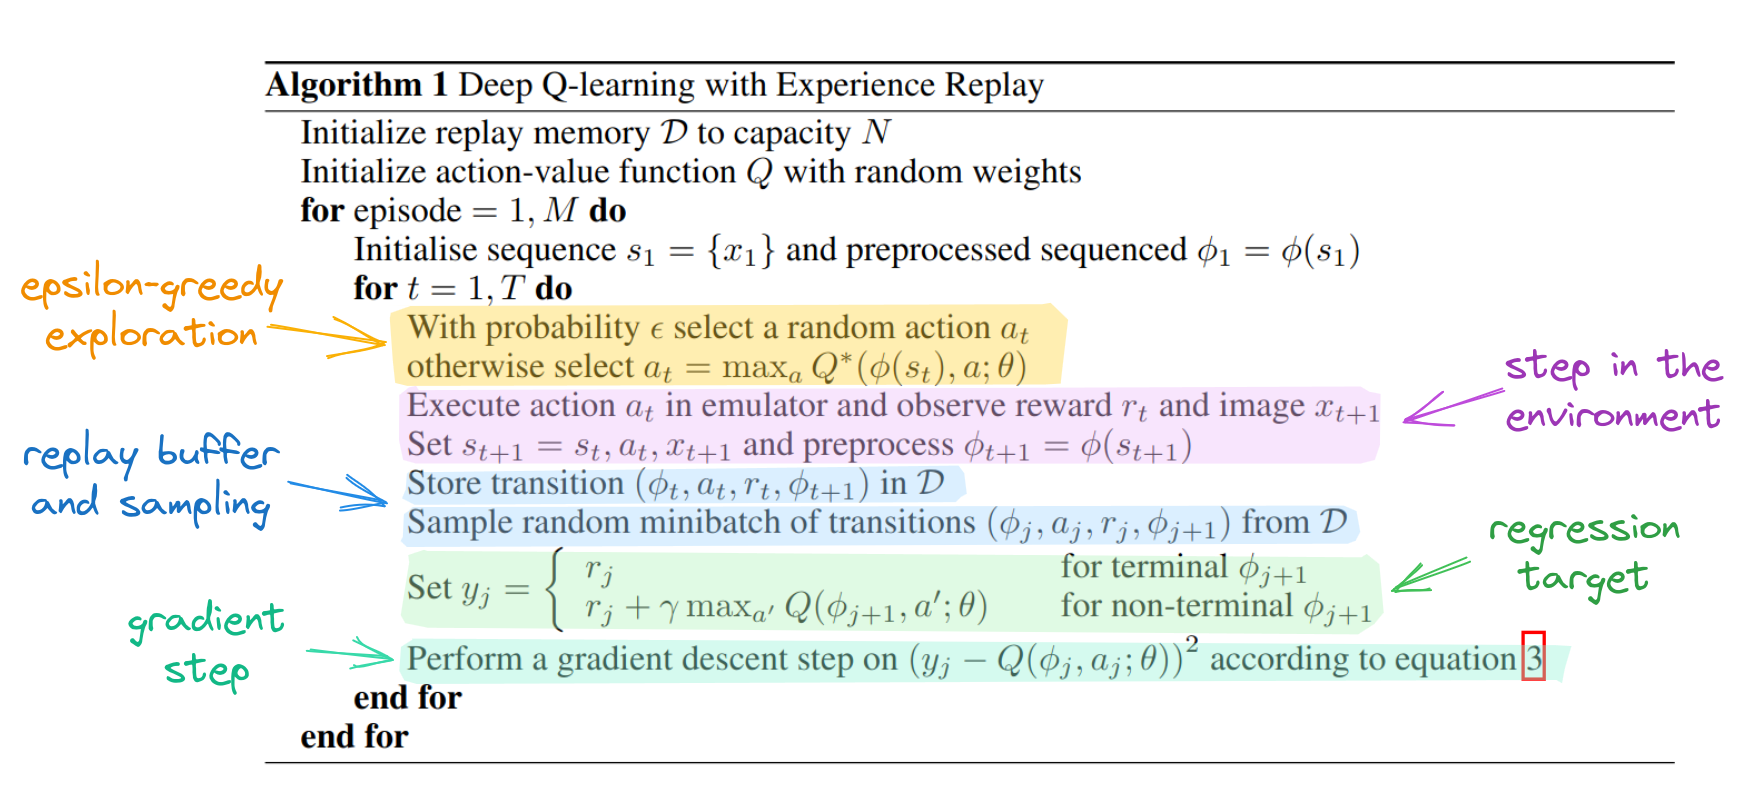
</div>


### Exercise (20 minutes): write DQN update

In [ ]:
def dqn_update_no_target(
    q_net: QNetwork,
    optimizer: th.optim.Optimizer,
    replay_buffer: ReplayBuffer,
    batch_size: int,
    gamma: float,
) -> None:
    """
    Perform one gradient step on the Q-network
    using the data from the replay buffer.
    Note: this is the same as dqn_update in dqn.py, but without the target network.

    :param q_net: The Q-network to update
    :param optimizer: The optimizer to use
    :param replay_buffer: The replay buffer containing the transitions
    :param batch_size: The minibatch size, how many transitions to sample
    :param gamma: The discount factor
    """
    ### YOUR CODE HERE

    # Sample the replay buffer and convert them to PyTorch tensors
    # using `.to_torch()` method
    replay_data = replay_buffer.sample(batch_size).to_torch()

    # We should not compute gradient with respect to the target
    with th.no_grad():
        # Compute the Q-values for the next observations (batch_size, n_actions)
        next_q_values = q_net(replay_data.next_observations)
        # Follow greedy policy: use the one with the highest value
        # shape: (batch_size,)
        next_q_values, _ = next_q_values.max(dim=1)
        # If the episode is terminated, set the target to the reward
        # (same as FQI, you can use `th.logical_not` to mask the next q values)
        should_bootstrap = th.logical_not(replay_data.terminated)
        # 1-step TD target
        td_target = replay_data.rewards + gamma * next_q_values * should_bootstrap

    # Get current Q-values estimates for the replay_data (batch_size, n_actions)
    q_values = q_net(replay_data.observations)
    # Select the Q-values corresponding to the actions that were selected
    # during data collection,
    # you should use `th.gather()`
    current_q_values = th.gather(q_values, dim=1, index=replay_data.actions)
    # Reshape from (batch_size, 1) to (batch_size,) to avoid broadcast error
    current_q_values = current_q_values.squeeze(dim=1)

    # Check for any shape/broadcast error
    # Current q-values must have the same shape as the TD target
    assert current_q_values.shape == (batch_size,), f"{current_q_values.shape} != {(batch_size,)}"
    assert current_q_values.shape == td_target.shape, f"{current_q_values.shape} != {td_target.shape}"

    # Compute the Mean Squared Error (MSE) loss
    # Optionally, one can use a Huber loss instead of the MSE loss
    loss = ((current_q_values - td_target) ** 2).mean()

    ### END OF YOUR CODE

    # Reset gradients
    optimizer.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the parameters of the q-network
    optimizer.step()

Let's test the implementation:

In [ ]:
env = gym.make("CartPole-v1")
q_net = QNetwork(env.observation_space, env.action_space)
optimizer = th.optim.Adam(q_net.parameters(), lr=0.001)
replay_buffer = ReplayBuffer(2000, env.observation_space, env.action_space)

obs, _ = env.reset()
# Let's collect some data following an epsilon-greedy policy
for _ in range(1000):
    obs = collect_one_step(env, q_net, replay_buffer, obs, exploration_rate=0.1)

# Try to do some gradient steps:
for _ in range(10):
    dqn_update_no_target(q_net, optimizer, replay_buffer, batch_size=32, gamma=0.99)

### Exercise (10 minutes): write the training loop

Let's put everything together and implement the training loop that alternates between data collection and updating the Q-Network.
At first we will not use any target network.

<div>
    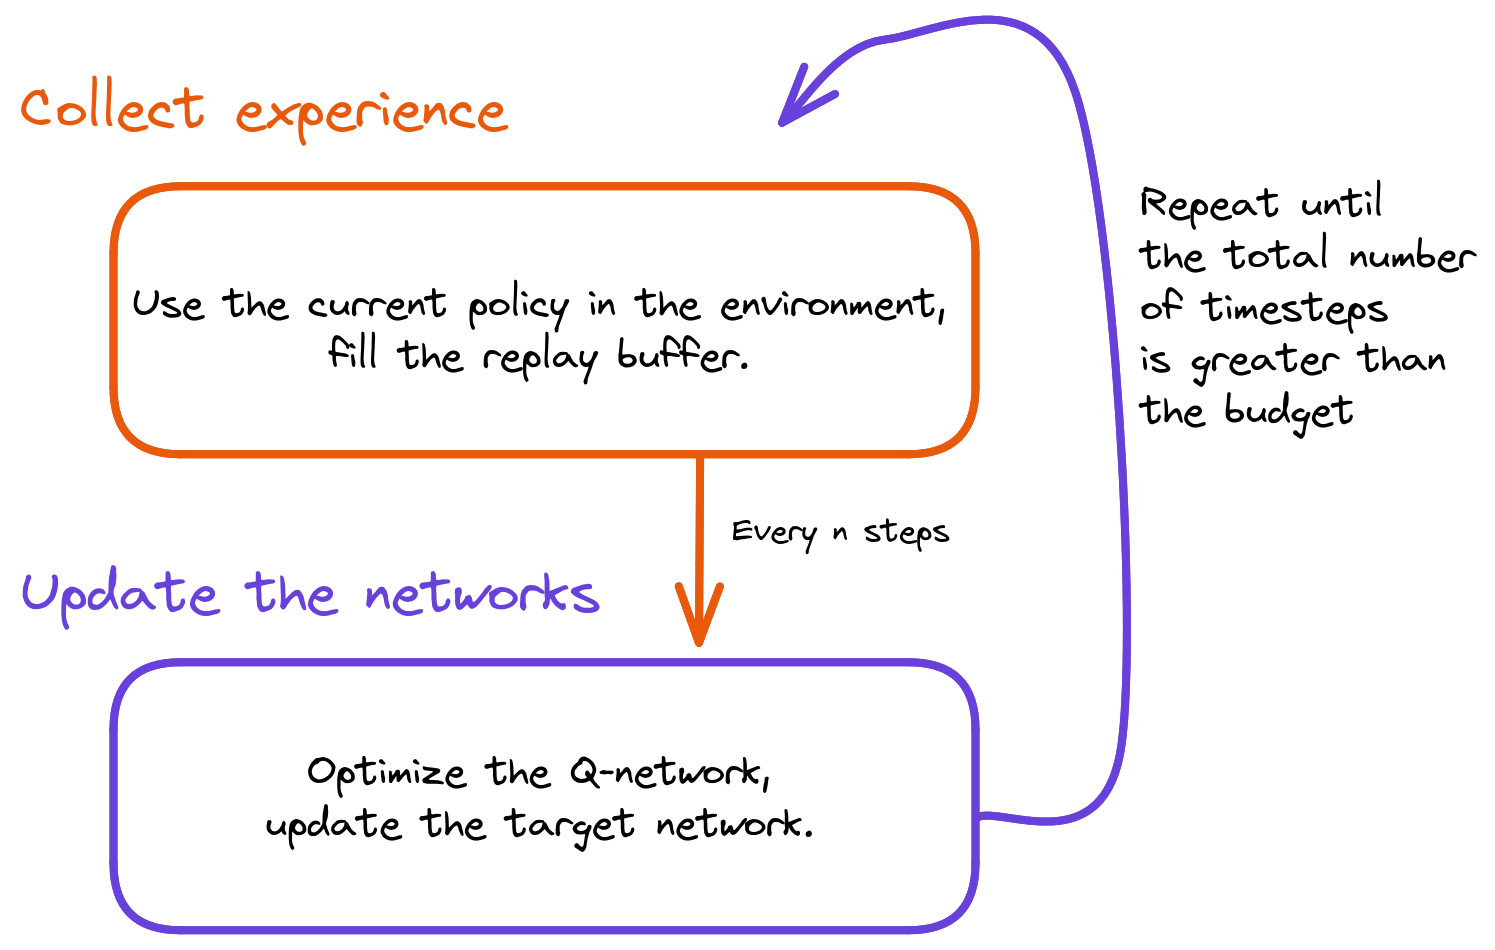
</div>

In [ ]:
def run_dqn_no_target(
    env_id: str = "CartPole-v1",
    replay_buffer_size: int = 50_000,
    # Exploration schedule
    # (for the epsilon-greedy data collection)
    exploration_initial_eps: float = 1.0,
    exploration_final_eps: float = 0.01,
    n_timesteps: int = 20_000,
    update_interval: int = 2,
    learning_rate: float = 3e-4,
    batch_size: int = 64,
    gamma: float = 0.99,
    n_eval_episodes: int = 10,
    evaluation_interval: int = 1000,
    eval_exploration_rate: float = 0.0,
    seed: int = 2023,
    # device: Union[th.device, str] = "cpu",
    eval_render_mode: Optional[str] = None,  # "human", "rgb_array", None
) -> QNetwork:
    """
    Run Deep Q-Learning (DQN) on a given environment.
    (without target network)

    :param env_id: Name of the environment
    :param replay_buffer_size: Max capacity of the replay buffer
    :param exploration_initial_eps: The initial exploration rate
    :param exploration_final_eps: The final exploration rate
    :param n_timesteps: Number of timesteps in total
    :param update_interval: How often to update the Q-network
        (every update_interval steps)
    :param learning_rate: The learning rate to use for the optimizer
    :param batch_size: The minibatch size
    :param gamma: The discount factor
    :param n_eval_episodes: The number of episodes to evaluate the policy on
    :param evaluation_interval: How often to evaluate the policy
    :param eval_exploration_rate: The exploration rate to use during evaluation
    :param seed: Random seed for the pseudo random generator
    :param eval_render_mode: The render mode to use for evaluation
    """
    # Set seed for reproducibility
    # Seed Numpy as PyTorch pseudo random generators
    # Seed Numpy RNG
    np.random.seed(seed)
    # seed the RNG for all devices (both CPU and CUDA)
    th.manual_seed(seed)

    # Create the environment
    env = gym.make(env_id)
    assert isinstance(env.observation_space, spaces.Box)
    assert isinstance(env.action_space, spaces.Discrete)
    env.action_space.seed(seed)

    # Create the evaluation environment
    eval_env = gym.make(env_id, render_mode=eval_render_mode)
    eval_env.reset(seed=seed)
    eval_env.action_space.seed(seed)

    ### YOUR CODE HERE
    # TODO:
    # 1. Instantiate the Q-Network and the optimizer
    # 2. Instantiate the replay buffer
    # 3. Compute the current exploration rate (epsilon)
    # 4. Collect new transition by stepping in the env following
    # an epsilon-greedy strategy
    # 5. Update the Q-Network using gradient descent

    # Create the q-network
    q_net = QNetwork(env.observation_space, env.action_space)
    # Create the optimizer (PyTorch `th.optim.Adam` will be helpful here)
    optimizer = th.optim.Adam(q_net.parameters(), lr=learning_rate)

    # Create the Replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size, env.observation_space, env.action_space)
    # Reset the env
    obs, _ = env.reset(seed=seed)

    for current_step in range(1, n_timesteps + 1):
        # Compute the current exploration rate
        # according to the exploration schedule (update the value of epsilon)
        # you should use `linear_schedule()`
        exploration_rate = linear_schedule(
            exploration_initial_eps,
            exploration_final_eps,
            current_step,
            n_timesteps,
        )
        # Do one step in the environment following an epsilon-greedy policy
        # and store the transition in the replay buffer
        # you can re-use `collect_one_step()`
        obs = collect_one_step(env, q_net, replay_buffer, obs, exploration_rate=exploration_rate)

        # Update the Q-Network every `update_interval` steps
        if (current_step % update_interval) == 0:
            # Do one gradient step (using `dqn_update_no_target()`)
            dqn_update_no_target(q_net, optimizer, replay_buffer, batch_size, gamma=gamma)

        ### END OF YOUR CODE

        if (current_step % evaluation_interval) == 0:
            print()
            print(f"Evaluation at step {current_step}:")
            # Evaluate the current greedy policy (deterministic policy)
            evaluate_policy(eval_env, q_net, n_eval_episodes, eval_exploration_rate=eval_exploration_rate)
    return q_net

## Train a DQN agent on CartPole environment

In [1]:
import os
# create log folder
os.makedirs("../logs/", exist_ok=True)

In [ ]:
env_id = "CartPole-v1"
q_net = run_dqn_no_target(env_id)

### Record and show video of the trained agent

In [ ]:
eval_env = gym.make(env_id, render_mode="rgb_array")
n_eval_episodes = 3
eval_exploration_rate = 0.0
video_name = f"DQN_no_target_{env_id}"

evaluate_policy(
    eval_env,
    q_net,
    n_eval_episodes,
    eval_exploration_rate=eval_exploration_rate,
    video_name=video_name,
)

show_videos("../logs/videos/", prefix=video_name)

## [Bonus] DQN Target Network


<div>
    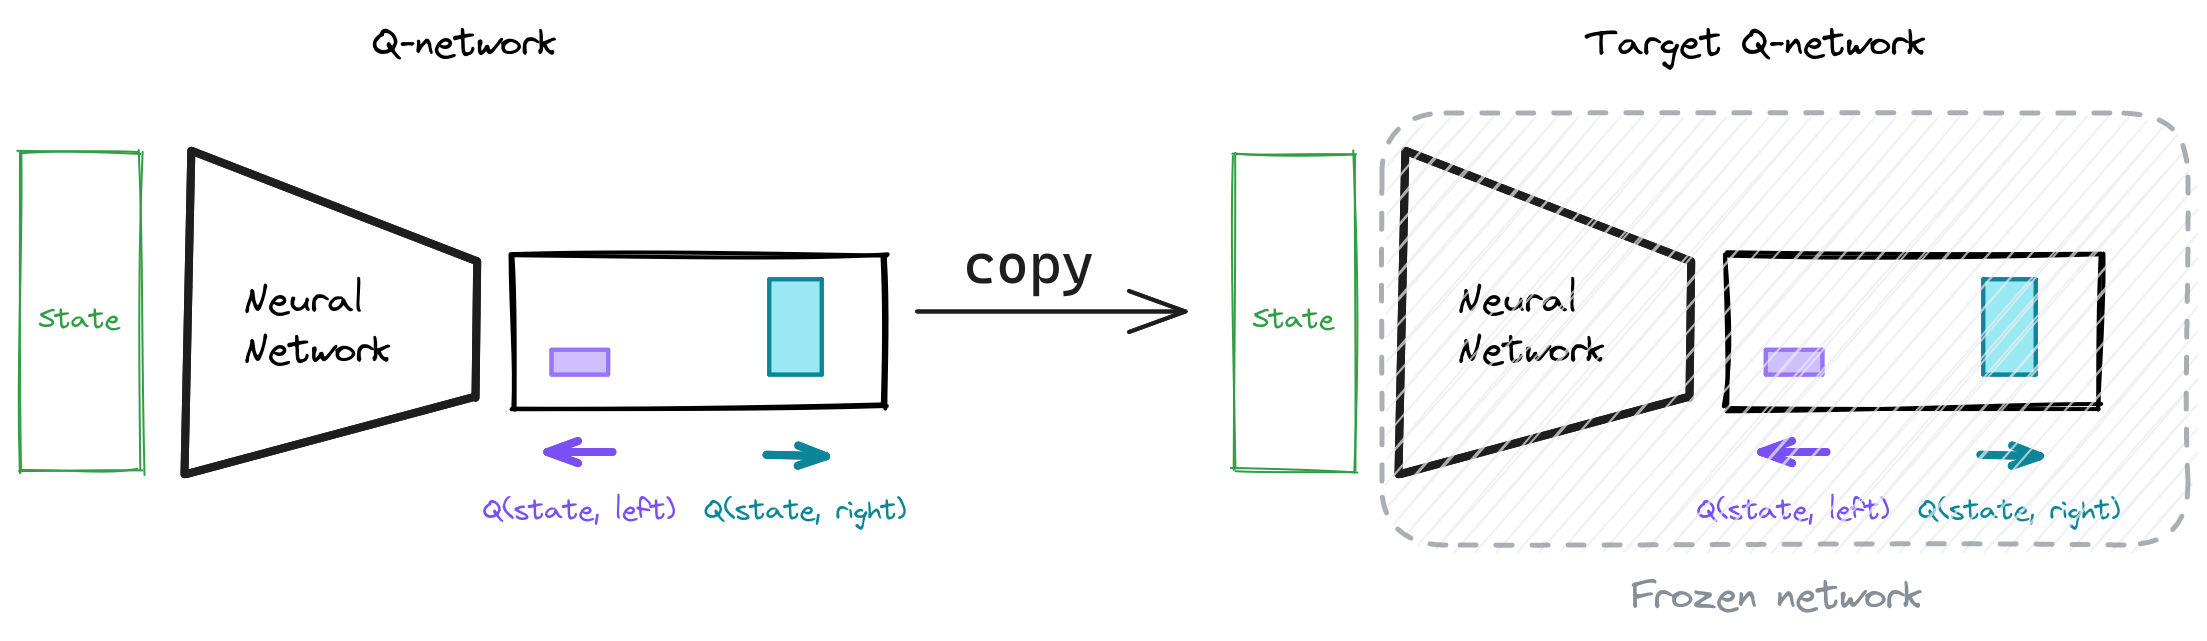
</div>

The only things that is changing is when predicting the next q value.

In DQN without target, the online network with weights **$\theta$** is used:

$y = r_t + \gamma \cdot \max_{a \in A}(\hat{Q}_{\pi}(s_{t+1}, a; \theta))$


whereas with DQN with target network, the target q-network (a delayed copy of the q-network) with weights **$\theta^\prime$** is used instead:

$y = r_t + \gamma \cdot \max_{a \in A}(\hat{Q}_{\pi}(s_{t+1}, a; \theta^\prime))$


### Exercise (5 minutes): write the DQN update with target network

In [ ]:
def dqn_update(
    q_net: QNetwork,
    q_target_net: QNetwork,
    optimizer: th.optim.Optimizer,
    replay_buffer: ReplayBuffer,
    batch_size: int,
    gamma: float,
) -> None:
    """
    Perform one gradient step on the Q-network
    using the data from the replay buffer.

    :param q_net: The Q-network to update
    :param q_target_net: The target Q-network, to compute the td-target.
    :param optimizer: The optimizer to use
    :param replay_buffer: The replay buffer containing the transitions
    :param batch_size: The minibatch size, how many transitions to sample
    :param gamma: The discount factor
    """

    # Sample the replay buffer and convert them to PyTorch tensors
    replay_data = replay_buffer.sample(batch_size).to_torch()

    with th.no_grad():
        ### YOUR CODE HERE
        # TODO: use the target q-network instead of the online q-network
        # to compute the next values

        # Compute the Q-values for the next observations (batch_size, n_actions)
        # using the target network
        next_q_values = q_target_net(replay_data.next_observations)
        # Follow greedy policy: use the one with the highest value
        # (batch_size,)
        next_q_values, _ = next_q_values.max(dim=1)
        # If the episode is terminated, set the target to the reward
        should_bootstrap = th.logical_not(replay_data.terminated)
        # 1-step TD target
        td_target = replay_data.rewards + gamma * next_q_values * should_bootstrap

        ### END OF YOUR CODE

    # Get current Q-values estimates for the replay_data (batch_size, n_actions)
    q_values = q_net(replay_data.observations)
    # Select the Q-values corresponding to the actions that were selected
    # during data collection
    current_q_values = th.gather(q_values, dim=1, index=replay_data.actions)
    # Reshape from (batch_size, 1) to (batch_size,) to avoid broadcast error
    current_q_values = current_q_values.squeeze(dim=1)

    # Check for any shape/broadcast error
    # Current q-values must have the same shape as the TD target
    assert current_q_values.shape == (batch_size,), f"{current_q_values.shape} != {(batch_size,)}"
    assert current_q_values.shape == td_target.shape, f"{current_q_values.shape} != {td_target.shape}"

    # Compute the Mean Squared Error (MSE) loss
    # Optionally, one can use a Huber loss instead of the MSE loss
    loss = ((current_q_values - td_target) ** 2).mean()
    # Huber loss
    # loss = th.nn.functional.smooth_l1_loss(current_q_values, td_target)

    # Reset gradients
    optimizer.zero_grad()
    # Compute the gradients
    loss.backward()
    # Update the parameters of the q-network
    optimizer.step()

### Updated training loop

In [ ]:
def run_dqn(
    env_id: str = "CartPole-v1",
    replay_buffer_size: int = 50_000,
    # How often do we copy the parameters from the Q-network to the target network
    target_network_update_interval: int = 1000,
    # Warmup phase
    learning_starts: int = 100,
    # Exploration schedule
    # (for the epsilon-greedy data collection)
    exploration_initial_eps: float = 1.0,
    exploration_final_eps: float = 0.01,
    exploration_fraction: float = 0.1,
    n_timesteps: int = 20_000,
    update_interval: int = 2,
    learning_rate: float = 3e-4,
    batch_size: int = 64,
    gamma: float = 0.99,
    n_hidden_units: int = 64,
    n_eval_episodes: int = 10,
    evaluation_interval: int = 1000,
    eval_exploration_rate: float = 0.0,
    seed: int = 2023,
    # device: Union[th.device, str] = "cpu",
    eval_render_mode: Optional[str] = None,  # "human", "rgb_array", None
) -> QNetwork:
    """
    Run Deep Q-Learning (DQN) on a given environment.
    (with a target network)

    :param env_id: Name of the environment
    :param replay_buffer_size: Max capacity of the replay buffer
    :param target_network_update_interval: How often do we copy the parameters
         to the target network
    :param learning_starts: Warmup phase to fill the replay buffer
        before starting the optimization.
    :param exploration_initial_eps: The initial exploration rate
    :param exploration_final_eps: The final exploration rate
    :param exploration_fraction: The fraction of the number of steps
        during which the exploration rate is annealed from
        initial_eps to final_eps.
        After this many steps, the exploration rate remains constant.
    :param n_timesteps: Number of timesteps in total
    :param update_interval: How often to update the Q-network
        (every update_interval steps)
    :param learning_rate: The learning rate to use for the optimizer
    :param batch_size: The minibatch size
    :param gamma: The discount factor
    :param n_hidden_units: Number of units for each hidden layer
        of the Q-Network.
    :param n_eval_episodes: The number of episodes to evaluate the policy on
    :param evaluation_interval: How often to evaluate the policy
    :param eval_exploration_rate: The exploration rate to use during evaluation
    :param seed: Random seed for the pseudo random generator
    :param eval_render_mode: The render mode to use for evaluation
    """
    # Set seed for reproducibility
    # Seed Numpy as PyTorch pseudo random generators
    # Seed Numpy RNG
    np.random.seed(seed)
    # seed the RNG for all devices (both CPU and CUDA)
    th.manual_seed(seed)

    # Create the environment
    env = gym.make(env_id)
    # For highway env
    env = gym.wrappers.FlattenObservation(env)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    assert isinstance(env.observation_space, spaces.Box)
    assert isinstance(env.action_space, spaces.Discrete)
    env.action_space.seed(seed)

    # Create the evaluation environment
    eval_env = gym.make(env_id, render_mode=eval_render_mode)
    eval_env = gym.wrappers.FlattenObservation(eval_env)
    eval_env.reset(seed=seed)
    eval_env.action_space.seed(seed)

    # Create the q-network
    q_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    # Create the target network
    q_target_net = QNetwork(env.observation_space, env.action_space, n_hidden_units=n_hidden_units)
    # Copy the parameters of the q-network to the target network
    q_target_net.load_state_dict(q_net.state_dict())

    # For flappy bird
    if env.observation_space.dtype == np.float64:
        q_net.double()
        q_target_net.double()

    # Create the optimizer, we only optimize the parameters of the q-network
    optimizer = th.optim.Adam(q_net.parameters(), lr=learning_rate)

    # Create the Replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size, env.observation_space, env.action_space)
    # Reset the env
    obs, _ = env.reset(seed=seed)
    for current_step in range(1, n_timesteps + 1):
        # Update the current exploration schedule (update the value of epsilon)
        exploration_rate = linear_schedule(
            exploration_initial_eps,
            exploration_final_eps,
            current_step,
            int(exploration_fraction * n_timesteps),
        )
        # Do one step in the environment following an epsilon-greedy policy
        # and store the transition in the replay buffer
        obs = collect_one_step(
            env,
            q_net,
            replay_buffer,
            obs,
            exploration_rate=exploration_rate,
            verbose=0,
        )

        # Update the target network
        # by copying the parameters from the Q-network every target_network_update_interval steps
        if (current_step % target_network_update_interval) == 0:
            q_target_net.load_state_dict(q_net.state_dict())

        # Update the Q-network every update_interval steps
        # after learning_starts steps have passed (warmup phase)
        if (current_step % update_interval) == 0 and current_step > learning_starts:
            # Do one gradient step
            dqn_update(q_net, q_target_net, optimizer, replay_buffer, batch_size, gamma=gamma)

        if (current_step % evaluation_interval) == 0:
            print()
            print(f"Evaluation at step {current_step}:")
            print(f"exploration_rate={exploration_rate:.2f}")
            # Evaluate the current greedy policy (deterministic policy)
            evaluate_policy(eval_env, q_net, n_eval_episodes, eval_exploration_rate=eval_exploration_rate)
            # Save a checkpoint
            th.save(q_net.state_dict(), f"../logs/q_net_checkpoint_{env_id}_{current_step}.pth")
    return q_net

## Train DQN agent with target network on CartPole env

In [ ]:
# Tuned hyperparameters from the RL Zoo3 of the Stable Baselines3 library
# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml

env_id = "CartPole-v1"

q_net = run_dqn(
    env_id=env_id,
    replay_buffer_size=100_000,
    # Note: you can remove the target network
    # by setting target_network_update_interval=1
    target_network_update_interval=10,
    learning_starts=1000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.04,
    exploration_fraction=0.1,
    n_timesteps=80_000,
    update_interval=2,
    learning_rate=1e-3,
    batch_size=64,
    gamma=0.99,
    n_eval_episodes=10,
    evaluation_interval=5000,
    # No exploration during evaluation
    # (deteministic policy)
    eval_exploration_rate=0.0,
    seed=2022,
)

### Visualize the trained agent

In [ ]:
eval_env = gym.make(env_id, render_mode="rgb_array")
n_eval_episodes = 3
eval_exploration_rate = 0.0
video_name = f"DQN_{env_id}"

# Optional: load checkpoint
# q_net = QNetwork(eval_env.observation_space, eval_env.action_space, n_hidden_units=64)
# q_net.load_state_dict(th.load("../logs/q_net_checkpoint_CartPole-v1_75000.pth"))

evaluate_policy(
    eval_env,
    q_net,
    n_eval_episodes,
    eval_exploration_rate=eval_exploration_rate,
    video_name=video_name,
)

show_videos("../logs/videos/", prefix=video_name)

## Training DQN agent on flappy bird:

You can go in the [GitHub repo](https://github.com/araffin/flappy-bird-gymnasium/tree/patch-1) to learn more about this environment.

<div>
    <img src="https://raw.githubusercontent.com/markub3327/flappy-bird-gymnasium/main/imgs/dqn.gif" width="300"/>
</div>


In [ ]:
!pip install "flappy-bird-gymnasium @ git+https://github.com/araffin/flappy-bird-gymnasium@patch-1"

In [ ]:
import flappy_bird_gymnasium  # noqa: F401

In [ ]:
env_id = "FlappyBird-v0"

q_net = run_dqn(
    env_id=env_id,
    replay_buffer_size=100_000,
    # Note: you can remove the target network
    # by setting target_network_update_interval=1
    target_network_update_interval=250,
    learning_starts=10_000,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.03,
    exploration_fraction=0.1,
    n_timesteps=500_000,
    update_interval=4,
    learning_rate=1e-3,
    batch_size=128,
    gamma=0.98,
    n_eval_episodes=5,
    evaluation_interval=50000,
    n_hidden_units=256,
    # No exploration during evaluation
    # (deteministic policy)
    eval_exploration_rate=0.0,
    seed=2023,
    eval_render_mode=None,
)

### Record a video of the trained agent

In [ ]:
eval_env = gym.make(env_id, render_mode="rgb_array")
n_eval_episodes = 3
eval_exploration_rate = 0.00
video_name = f"DQN_{env_id}"


# Optional: load checkpoint
q_net = QNetwork(eval_env.observation_space, eval_env.action_space, n_hidden_units=256)
# Convert weights from float32 to float64 to match flappy bird obs
q_net.double()
q_net.load_state_dict(th.load("../logs/q_net_checkpoint_FlappyBird-v0_200000.pth"))

evaluate_policy(
    eval_env,
    q_net,
    n_eval_episodes,
    eval_exploration_rate=eval_exploration_rate,
    video_name=video_name,
)

show_videos("../logs/videos/", prefix=video_name)

### Going further

- analyse the learned q-values
- explore different value for the target update, use soft update instead of hard-copy
- experiment with Huber loss (smooth l1 loss) instead of l2 loss (mean squared error)
- play with different environments
- implement a CNN to play flappybird/pong from pixels (need to stack frames)
- implement DQN extensions (double Q-learning, prioritized experience replay, ...)

## Conclusion

In this notebook, you have seen how to implement the DQN algorithm (update rule and training loop) using all the components from part I (replay buffer, epsilon-greedy exploration strategy, Q-Network, ...).